#### Import relevant libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns


In [2]:
sns.set()

### Import relevant Data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
rainfall_df = pd.read_csv("/content/drive/MyDrive/Documents/Omdena Solar Energy Project/task3/Average_rainfall_2010-2011.csv")
rainfall_df.head(3)

,OID,NAME,MIN,MAX,MEAN(mm)
0,355,Aba North,2490.562838,2555.951757,2526.869030
1,365,Aba South,2490.562838,2612.054258,2574.278778
2,156,Abadam,197.910887,363.210023,1.000000


In [6]:
stats_df = pd.read_csv("/content/drive/MyDrive/Documents/Omdena Solar Energy Project/task3/nga_lga_zonal_statistics_2016.csv")
stats_df.head(3)

,mean,system:index,AREA,LGA,STATE,Latitude,Longitude,PERIMETER
0,0.005794,0,1193.977,Gada,Sokoto,13.673474,5.376003,170.095
1,-0.005185,1,1298.423,Illela,Sokoto,13.686694,5.724052,174.726
2,0.006878,2,2460.715,Tangaza,Sokoto,13.477057,5.000714,209.702


### Let's tidy up a little 

In [7]:
# just gonna use mean rainfall data so i'd extract that and lga name
rainfall_df = rainfall_df.loc[:, ('NAME', 'MEAN(mm)')]
rainfall_df.rename(columns = {"NAME":"LGA","MEAN(mm)":"mean_rainfall"},inplace=True)
# drop first two columns in rainfall data
stats_df = stats_df.loc[:, ("AREA","LGA","STATE","Latitude","Longitude","PERIMETER")]
stats_df

rainfall_df["LGA"] = rainfall_df["LGA"].str.lower()
stats_df["LGA"] = stats_df["LGA"].str.lower()


In [8]:
rainfall_df['LGA'] = rainfall_df['LGA'].astype(str).apply(lambda x: x.replace('-', '')).astype(str)
rainfall_df['LGA'] = rainfall_df['LGA'].astype(str).apply(lambda x: x.replace('/', '')).astype(str)
rainfall_df['LGA'] = rainfall_df['LGA'].astype(str).apply(lambda x: x.replace(' ', '')).astype(str)
stats_df['LGA'] = stats_df['LGA'].astype(str).apply(lambda x: x.replace('-', '')).astype(str)
stats_df['LGA'] = stats_df['LGA'].astype(str).apply(lambda x: x.replace('/', '')).astype(str)
stats_df['LGA'] = stats_df['LGA'].astype(str).apply(lambda x: x.replace(' ', '')).astype(str)

In [9]:
rainfall_df

,LGA,mean_rainfall
0,abanorth,2526.869030
1,abasouth,2574.278778
2,abadam,1.000000
3,abaji,1402.670330
4,abak,2647.566615
...,...,...
764,zangonkataf,1616.447151
765,zaria,1201.544454
766,zing,1358.980766
767,zurmi,771.563303


#### Combine the two df's

In [10]:
combined_df = pd.merge(stats_df,rainfall_df, on = "LGA")
combined_df
# we've lost a little less than 5% of the data

,AREA,LGA,STATE,Latitude,Longitude,PERIMETER,mean_rainfall
0,1193.977,gada,Sokoto,13.673474,5.376003,170.095,643.706741
1,1298.423,illela,Sokoto,13.686694,5.724052,174.726,1.000000
2,2460.715,tangaza,Sokoto,13.477057,5.000714,209.702,1.000000
3,2430.515,abadam,Borno,13.364860,13.186987,288.957,1.000000
4,2241.750,sabonbirni,Sokoto,13.480609,6.266446,201.102,617.765536
...,...,...,...,...,...,...,...
733,388.510,ethiopeeast,Delta,5.687991,5.984137,115.623,2435.641259
734,485.467,isokonorth,Delta,5.524931,6.234139,169.369,2504.751652
735,3951.431,lavun,Niger,9.273478,5.683300,424.153,1224.501063
736,7795.261,maru,Zamfara,11.486078,6.342003,536.500,1165.761681


## Data Cleaning

In [11]:
combined_df["mean_rainfall"].min()

1.0

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


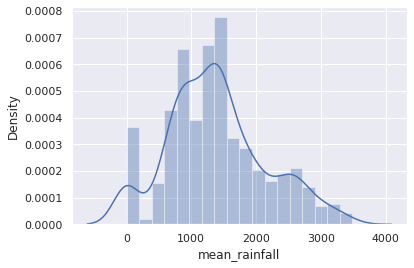

In [12]:
sns.distplot(combined_df["mean_rainfall"])
plt.show()

In [13]:
#I think the minimum value of 1 might be an error I'd replace that with
#the median value
combined_df["mean_rainfall"] =combined_df["mean_rainfall"].replace\
(1,combined_df["mean_rainfall"].median())

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


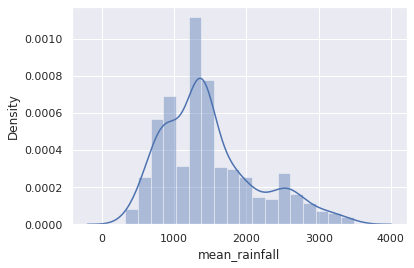

In [14]:
sns.distplot(combined_df["mean_rainfall"])
plt.show()

In [15]:
combined_df["mean_rainfall"].min()

320.120937

### Feature Engineering/ Estimate groundwater recharge due to rainfall

Due to the lack of sufficient data for groundwater estimation we'd use rainfall data. 

According to research 25% of precipitation returns to groundwater so let's calculate how much that 25% is by creating the following features below.
**Rain rate**: This is given by the average amount of yearly rainfall divided by the total number of hours in a year.

**The Chaturvedi Formula**: Used to estimate how much of rainfall recharges groundwater... i.e estimate our 25%. There are several other formulas or ways to estimate this... A direct approach would be to put our yearly rainfall in mm and get the volume per given area and divide by 4 (or multiply by .25).

Modified Chaturvedi Formula $R$ = $1.35$ $(P-14)$$^.5$


So using this amount given in inches we'd estimate the total volume of rainfall that's part of groundwater for certain areas. Convert the value back to mm and then calculate volume in mm$^3$.




In [16]:
#let's define some useful functions
def rain_rate(x):
    return (round(x/8760,2))
def mm_to_inches(x):
    return(round(x/25.4,4))
def inches_to_mm(x):
    return(round(x*25.4,4))
def chaturvedi(x):
    return(round(abs(1.35*((x-14)**.5)),2))
def rain_vol(x,y):
    """ x is the amount of rainfall and y is the area of given lga
    1mm of rainfall = 1(litre/m^2)
    convert area given in km^2 to m^2
    so 1(litre/m^2) *1m^2 = 1litre
    1litre = 0.001
    divide by 1000 to convert to m^3
    
    """
    z = y * 1000000 
    volume = x * z
    return(round(volume,2))


In [17]:
combined_df["rain_rate(mm/hr)"] = combined_df["mean_rainfall"].map(lambda x: rain_rate(x))
combined_df["mean_rain(inches)"] = combined_df["mean_rainfall"].map(lambda x: mm_to_inches(x))
combined_df["chaturvedi(inches)"] = combined_df["mean_rain(inches)"].map(lambda x: chaturvedi(x))
combined_df["chaturvedi(mm)"] = combined_df["chaturvedi(inches)"].map(lambda x: inches_to_mm(x))
combined_df["rain_vol(m3)"] = rain_vol(combined_df["chaturvedi(mm)"],combined_df["AREA"])
combined_df






,AREA,LGA,STATE,Latitude,Longitude,PERIMETER,mean_rainfall,rain_rate(mm/hr),mean_rain(inches),chaturvedi(inches),chaturvedi(mm),rain_vol(m3)
0,1193.977,gada,Sokoto,13.673474,5.376003,170.095,643.706741,0.07,25.3428,4.55,115.570,1.379879e+11
1,1298.423,illela,Sokoto,13.686694,5.724052,174.726,1338.335470,0.15,52.6904,8.40,213.360,2.770315e+11
2,2460.715,tangaza,Sokoto,13.477057,5.000714,209.702,1338.335470,0.15,52.6904,8.40,213.360,5.250182e+11
3,2430.515,abadam,Borno,13.364860,13.186987,288.957,1338.335470,0.15,52.6904,8.40,213.360,5.185747e+11
4,2241.750,sabonbirni,Sokoto,13.480609,6.266446,201.102,617.765536,0.07,24.3215,4.34,110.236,2.471216e+11
...,...,...,...,...,...,...,...,...,...,...,...,...
733,388.510,ethiopeeast,Delta,5.687991,5.984137,115.623,2435.641259,0.28,95.8914,12.22,310.388,1.205888e+11
734,485.467,isokonorth,Delta,5.524931,6.234139,169.369,2504.751652,0.29,98.6123,12.42,315.468,1.531493e+11
735,3951.431,lavun,Niger,9.273478,5.683300,424.153,1224.501063,0.14,48.2087,7.90,200.660,7.928941e+11
736,7795.261,maru,Zamfara,11.486078,6.342003,536.500,1165.761681,0.13,45.8961,7.62,193.548,1.508757e+12


In [19]:
drive.mount('/content/drive')
!estimate_underground_water_with_rainfall.ipynb/content/drive/MyDrive

Mounted at /content/drive
/bin/bash: estimate_underground_water_with_rainfall.ipynb/content/drive/MyDrive: No such file or directory
